In [1]:
import pandas as pd
from obspy.core import UTCDateTime
stats = pd.read_csv('sta_log_long.txt', sep='|', header=0)
color_list = []
stats = stats.groupby('Station').agg({'StartTime': 'min', 'EndTime': 'max','Latitude': 'first', 'Longitude': 'first', 'Elevation': 'first'}).reset_index()
for i,row in stats.iterrows():
    dt = UTCDateTime(row.EndTime)-UTCDateTime(row.StartTime) # in sec
    if dt < (60*60*24*30): # 30d in sec
        stats.drop(i, inplace=True)
     
    else:
        if UTCDateTime(row.EndTime)<UTCDateTime("2000-01-01"): # only 1980
            color_list.append('orange')

        elif UTCDateTime(row.StartTime)>UTCDateTime("2000-01-01"): # only 2004
            color_list.append('red')

        else:
            color_list.append('blue')
stats['color'] = color_list
stats = stats.reset_index(drop=True)
print(stats.shape)
stats.head()

(57, 7)


,Station,StartTime,EndTime,Latitude,Longitude,Elevation,color
0,APE,1980-03-23T00:00:00,1980-06-15T00:00:00,46.099461,-122.207497,579.0,orange
1,ASH,1981-05-13T00:00:00,1981-09-15T23:59:59,46.200668,-122.185471,1900.0,orange
2,B201,2007-09-12T00:00:00,2599-12-31T23:59:59,46.303299,-122.264801,990.0,red
3,B202,2007-07-25T00:00:00,2599-12-31T23:59:59,46.244701,-122.136703,1218.6,red
4,B203,2007-07-18T00:00:00,2599-12-31T23:59:59,46.168999,-122.333664,814.4,red


grdcut [WARNING]: (w - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
grdcut [WARNING]: w reset from -122.407552 to -122.408333333
grdcut [WARNING]: (e - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
grdcut [WARNING]: e reset from -121.990962 to -121.990833333
grdcut [WARNING]: (s - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
grdcut [WARNING]: s reset from 46.049461 to 46.0491666667
grdcut [WARNING]: (n - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
grdcut [WARNING]: n reset from 46.40067 to 46.4008333333


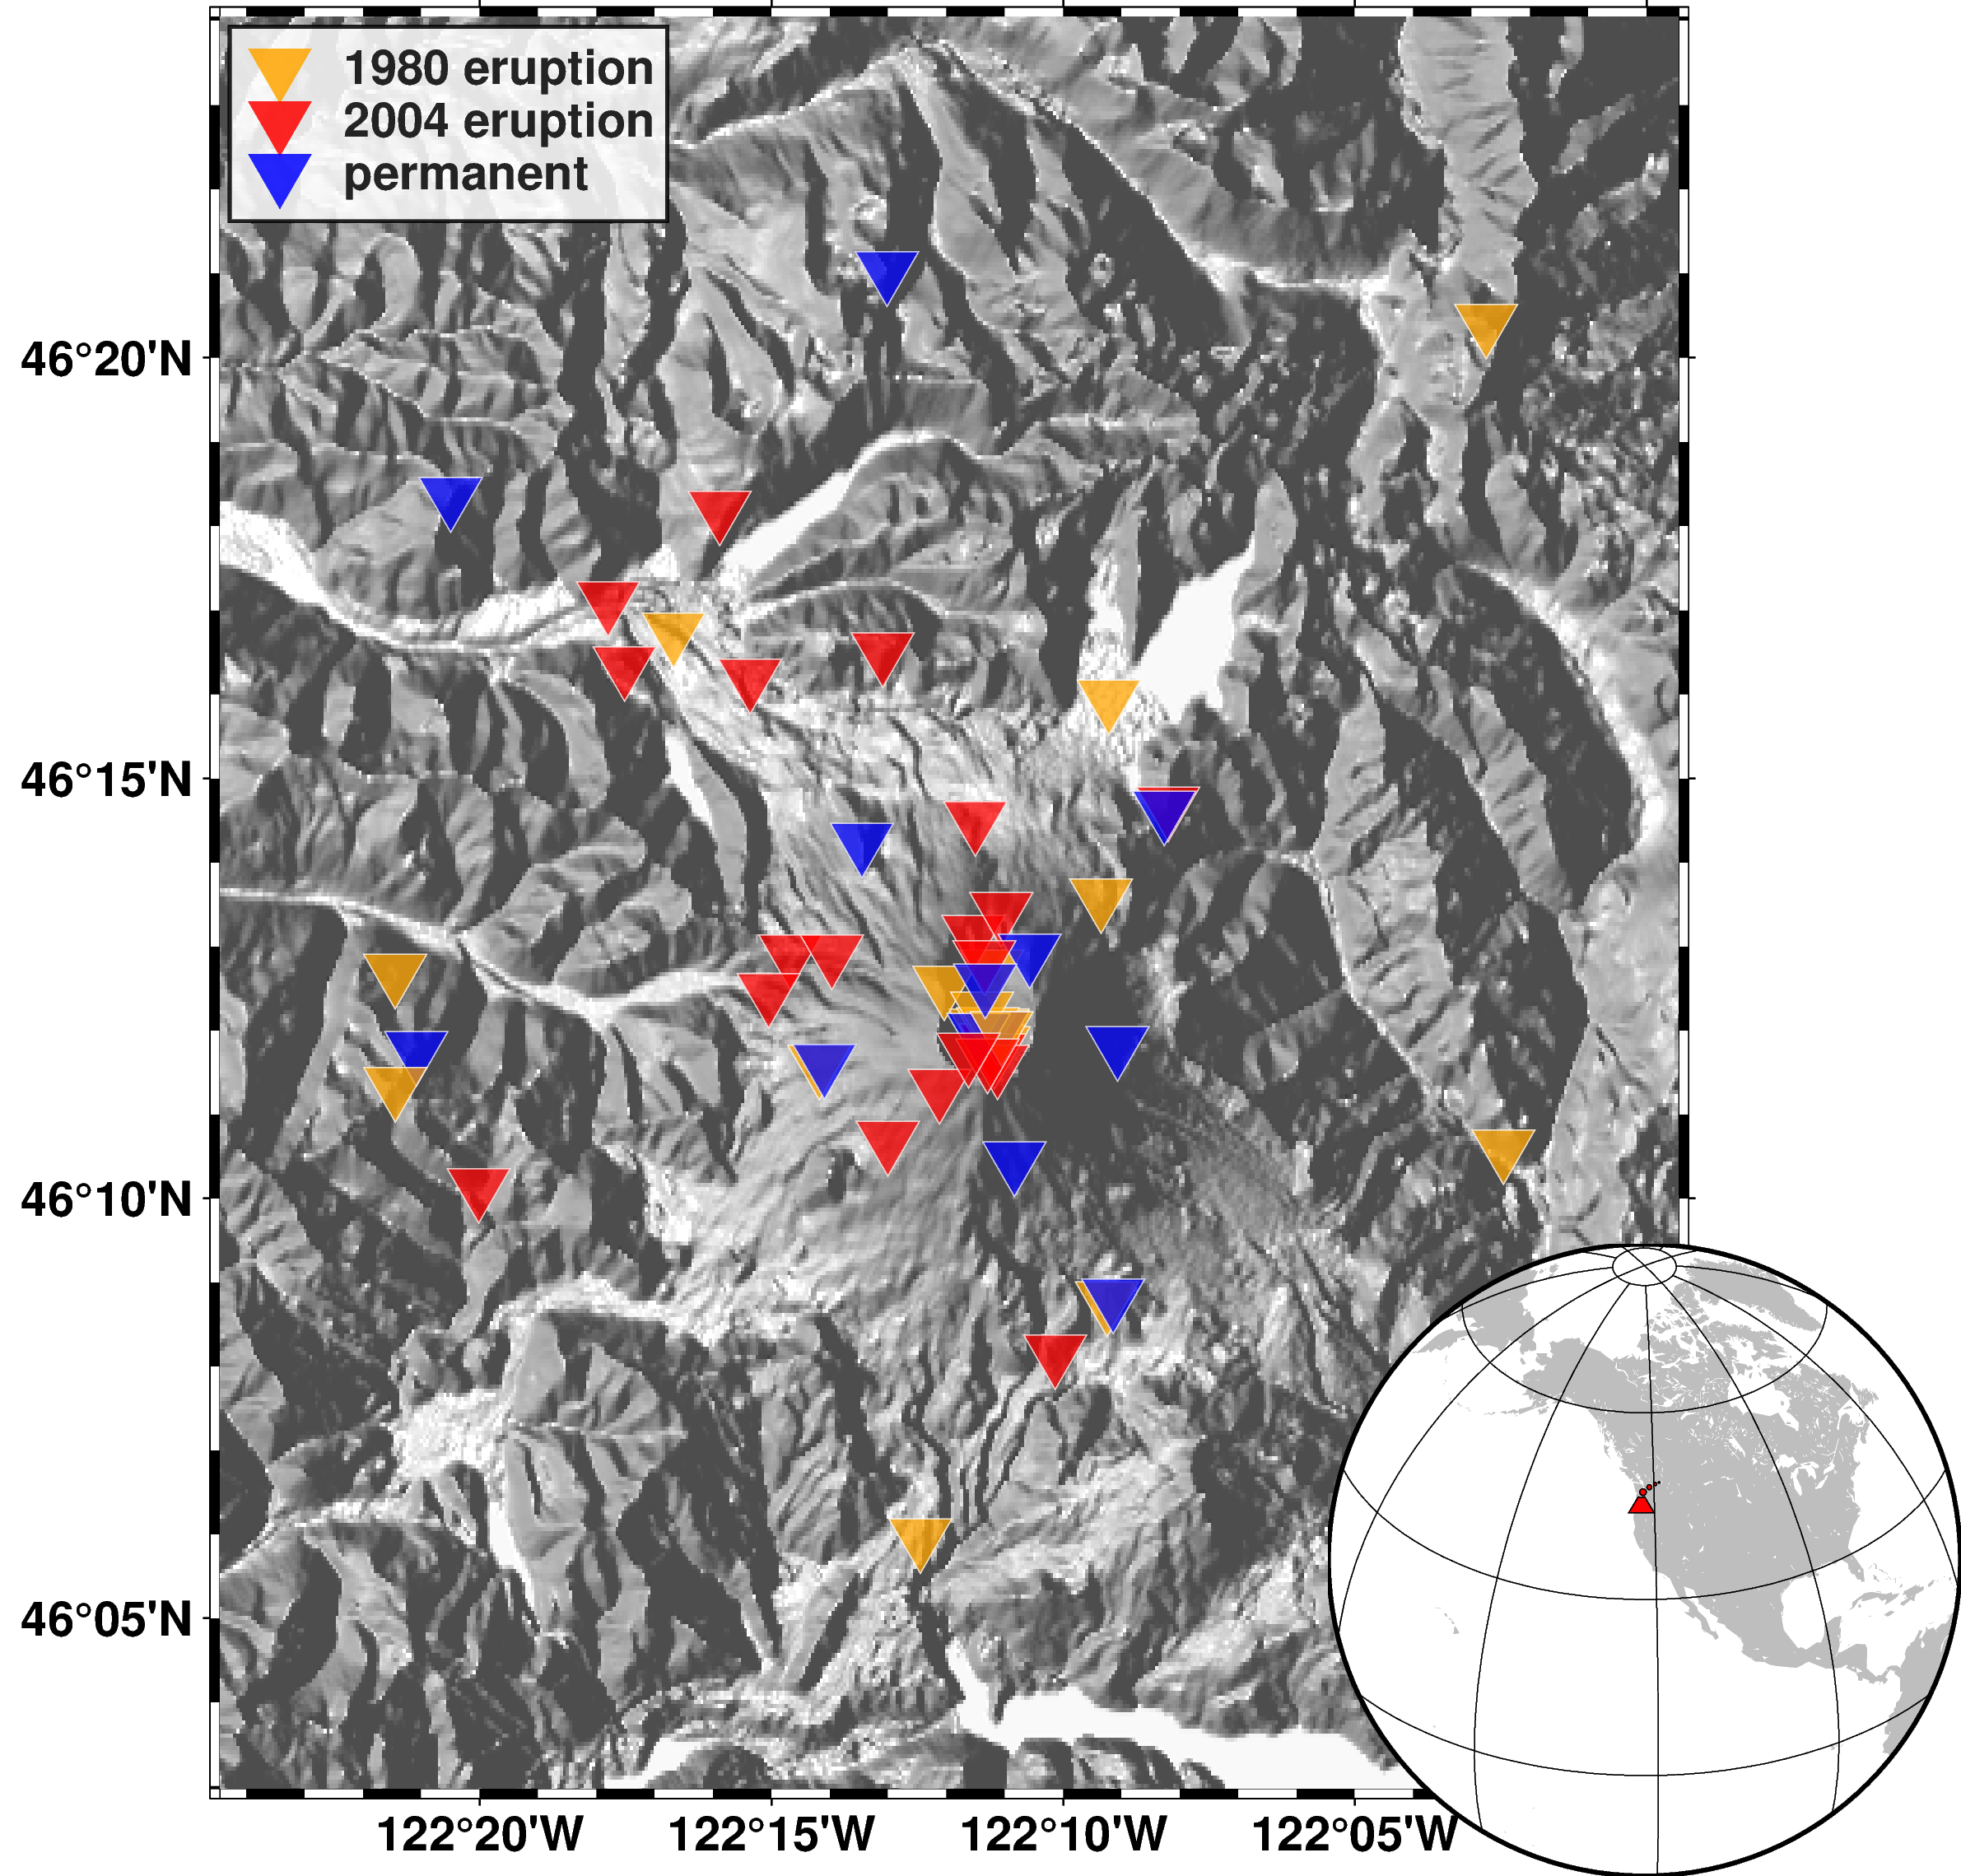

In [9]:
import numpy as np
import pygmt
import pandas as pd


# stats = pd.read_csv('sta_log_long.txt', sep='|', header=0)
# 2 is lat 3 is lon
region = [
    stats.Longitude.min() - .05,
    stats.Longitude.max() + .05,
    stats.Latitude.min() - .05,
    stats.Latitude.max() + .05,
]

helen = (46.191, -122.196)



pygmt.config(FONT='14p,Helvetica-Bold')
pygmt.makecpt(cmap="gray", series=[-1.5, 0.3, 0.01])
fig = pygmt.Figure()
# Load sample grid (3 arc-seconds global relief) in target area
grid = pygmt.datasets.load_earth_relief(resolution='03s', region=region)
# calculate the reflection of a light source projecting from west to east
# (azimuth of 270 degrees) and at a latitude of 30 degrees from the horizon
dgrid = pygmt.grdgradient(grid=grid, radiance=[270, 30])

fig.basemap(region=region, projection="M15c", frame=True)
fig.grdimage(grid=dgrid, projection="M15c", cmap=True) #cmap="geo")

for i in stats.index:
    fig.plot(
        x=stats.Longitude[i], y=stats.Latitude[i], style="i0.75c",
        fill=stats.color[i],pen="white", transparency=25)
    
# legende
fig.plot(
    x=np.nan, y=np.nan, style="i0.75c",
    fill='orange', transparency=25,
    label='1980 eruption')
fig.plot(
    x=np.nan, y=np.nan, style="i0.75c",
    fill='red', transparency=25,
    label='2004 eruption')
fig.plot(
    x=np.nan, y=np.nan, style="i0.75c",
    fill='blue', transparency=25,
    label='permanent')

# fig.plot(
#     x=stats.Longitude[1], y=stats.Latitude[1], style="i0.9c", color="black",
#     pen="white", label=f'{stats.Network[1]}.{stats.Station[1]}')
# fig.plot(
#     x=stats.Longitude[2], y=stats.Latitude[2], style="i0.9c", color="magenta",
#     pen="white", label=f'{stats.Network[2]}.{stats.Station[2]}')
# fig.plot(
#     x=stats.Longitude[3], y=stats.Latitude[3], style="i0.9c", color="blue",
#     pen="white", label=f'{stats.Network[3]}.{stats.Station[3]}')
fig.legend(
    transparency=15, box="+gwhite+p1p", position="jTL+jTL+w4.5c/2.c+o0.1c")

# fig.plot(
#     x=helen[1], y=helen[0], style="kvolcano/1c", color="red", pen="white",
#     label='Volcanoes')

# fig.colorbar(frame=["a2000", "x+lElevation", "y+lm"])

lonmid = (region[0] + region[1])/2
latmid = (region[2] + region[3])/2 - 10
with fig.inset(position="jBR+w6.5c/6.5c+o-2.9c/-.9c"):
    fig.coast(
        projection=f"G{lonmid}/{latmid}/60/6.5c", region="g", frame="g",
        land="gray", water='white')
    fig.plot(
        x=helen[1], y=helen[0], style="kvolcano/0.33c", fill="red",
        pen="black", projection=f"G{lonmid}/{latmid}/60/6.5c")

# fig.savefig('station_map_1980_2004_hillshade2.png', dpi=300, transparent=True)
fig.show()


In [10]:
import numpy as np
import pygmt
import pandas as pd
from obspy.core import UTCDateTime
from matplotlib.pyplot import cm
# color = cm.viridis(np.linspace(0, 1, 3))[:,:3]

color = cm.viridis(np.linspace(0, 1, 3))[:,:3]
color *= 256
color = color.astype(int)

stats = pd.read_csv('sta_log_long.txt', sep='|', header=0)
color_list = []
stats = stats.groupby('Station').agg({'StartTime': 'min', 'EndTime': 'max','Latitude': 'first', 'Longitude': 'first', 'Elevation': 'first'}).reset_index()
for i,row in stats.iterrows():
    dt = UTCDateTime(row.EndTime)-UTCDateTime(row.StartTime) # in sec
    if dt < (60*60*24*30) or UTCDateTime(row.StartTime)>UTCDateTime("2009-01-01"): # 30d in sec
        stats.drop(i, inplace=True)
     
    else:
        if UTCDateTime(row.EndTime)<UTCDateTime("2000-01-01"): # only 1980
            color_list.append(color[0])

        elif UTCDateTime(row.StartTime)>UTCDateTime("2000-01-01"): # only 2004
            color_list.append(color[2])

        else:
            color_list.append(color[1])

stats['color'] = color_list
            
color_str_list = []
for i in stats.index:
    color_str_list.append("/".join(map(str, stats.color[i])))
            
stats['str_color'] = color_str_list
color_str_list  = np.unique(color_str_list)
stats = stats.reset_index(drop=True)
print(stats.shape)
stats.head()

(47, 8)


,Station,StartTime,EndTime,Latitude,Longitude,Elevation,color,str_color
0,APE,1980-03-23T00:00:00,1980-06-15T00:00:00,46.099461,-122.207497,579.0,"[68, 1, 84]",68/1/84
1,ASH,1981-05-13T00:00:00,1981-09-15T23:59:59,46.200668,-122.185471,1900.0,"[68, 1, 84]",68/1/84
2,B201,2007-09-12T00:00:00,2599-12-31T23:59:59,46.303299,-122.264801,990.0,"[254, 231, 36]",254/231/36
3,B202,2007-07-25T00:00:00,2599-12-31T23:59:59,46.244701,-122.136703,1218.6,"[254, 231, 36]",254/231/36
4,B203,2007-07-18T00:00:00,2599-12-31T23:59:59,46.168999,-122.333664,814.4,"[254, 231, 36]",254/231/36


grdcut [WARNING]: (w - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
grdcut [WARNING]: w reset from -122.407552 to -122.408333333
grdcut [WARNING]: (e - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
grdcut [WARNING]: e reset from -121.990962 to -121.990833333
grdcut [WARNING]: (s - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
grdcut [WARNING]: s reset from 46.049461 to 46.0491666667
grdcut [WARNING]: (n - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
grdcut [WARNING]: n reset from 46.40067 to 46.4008333333


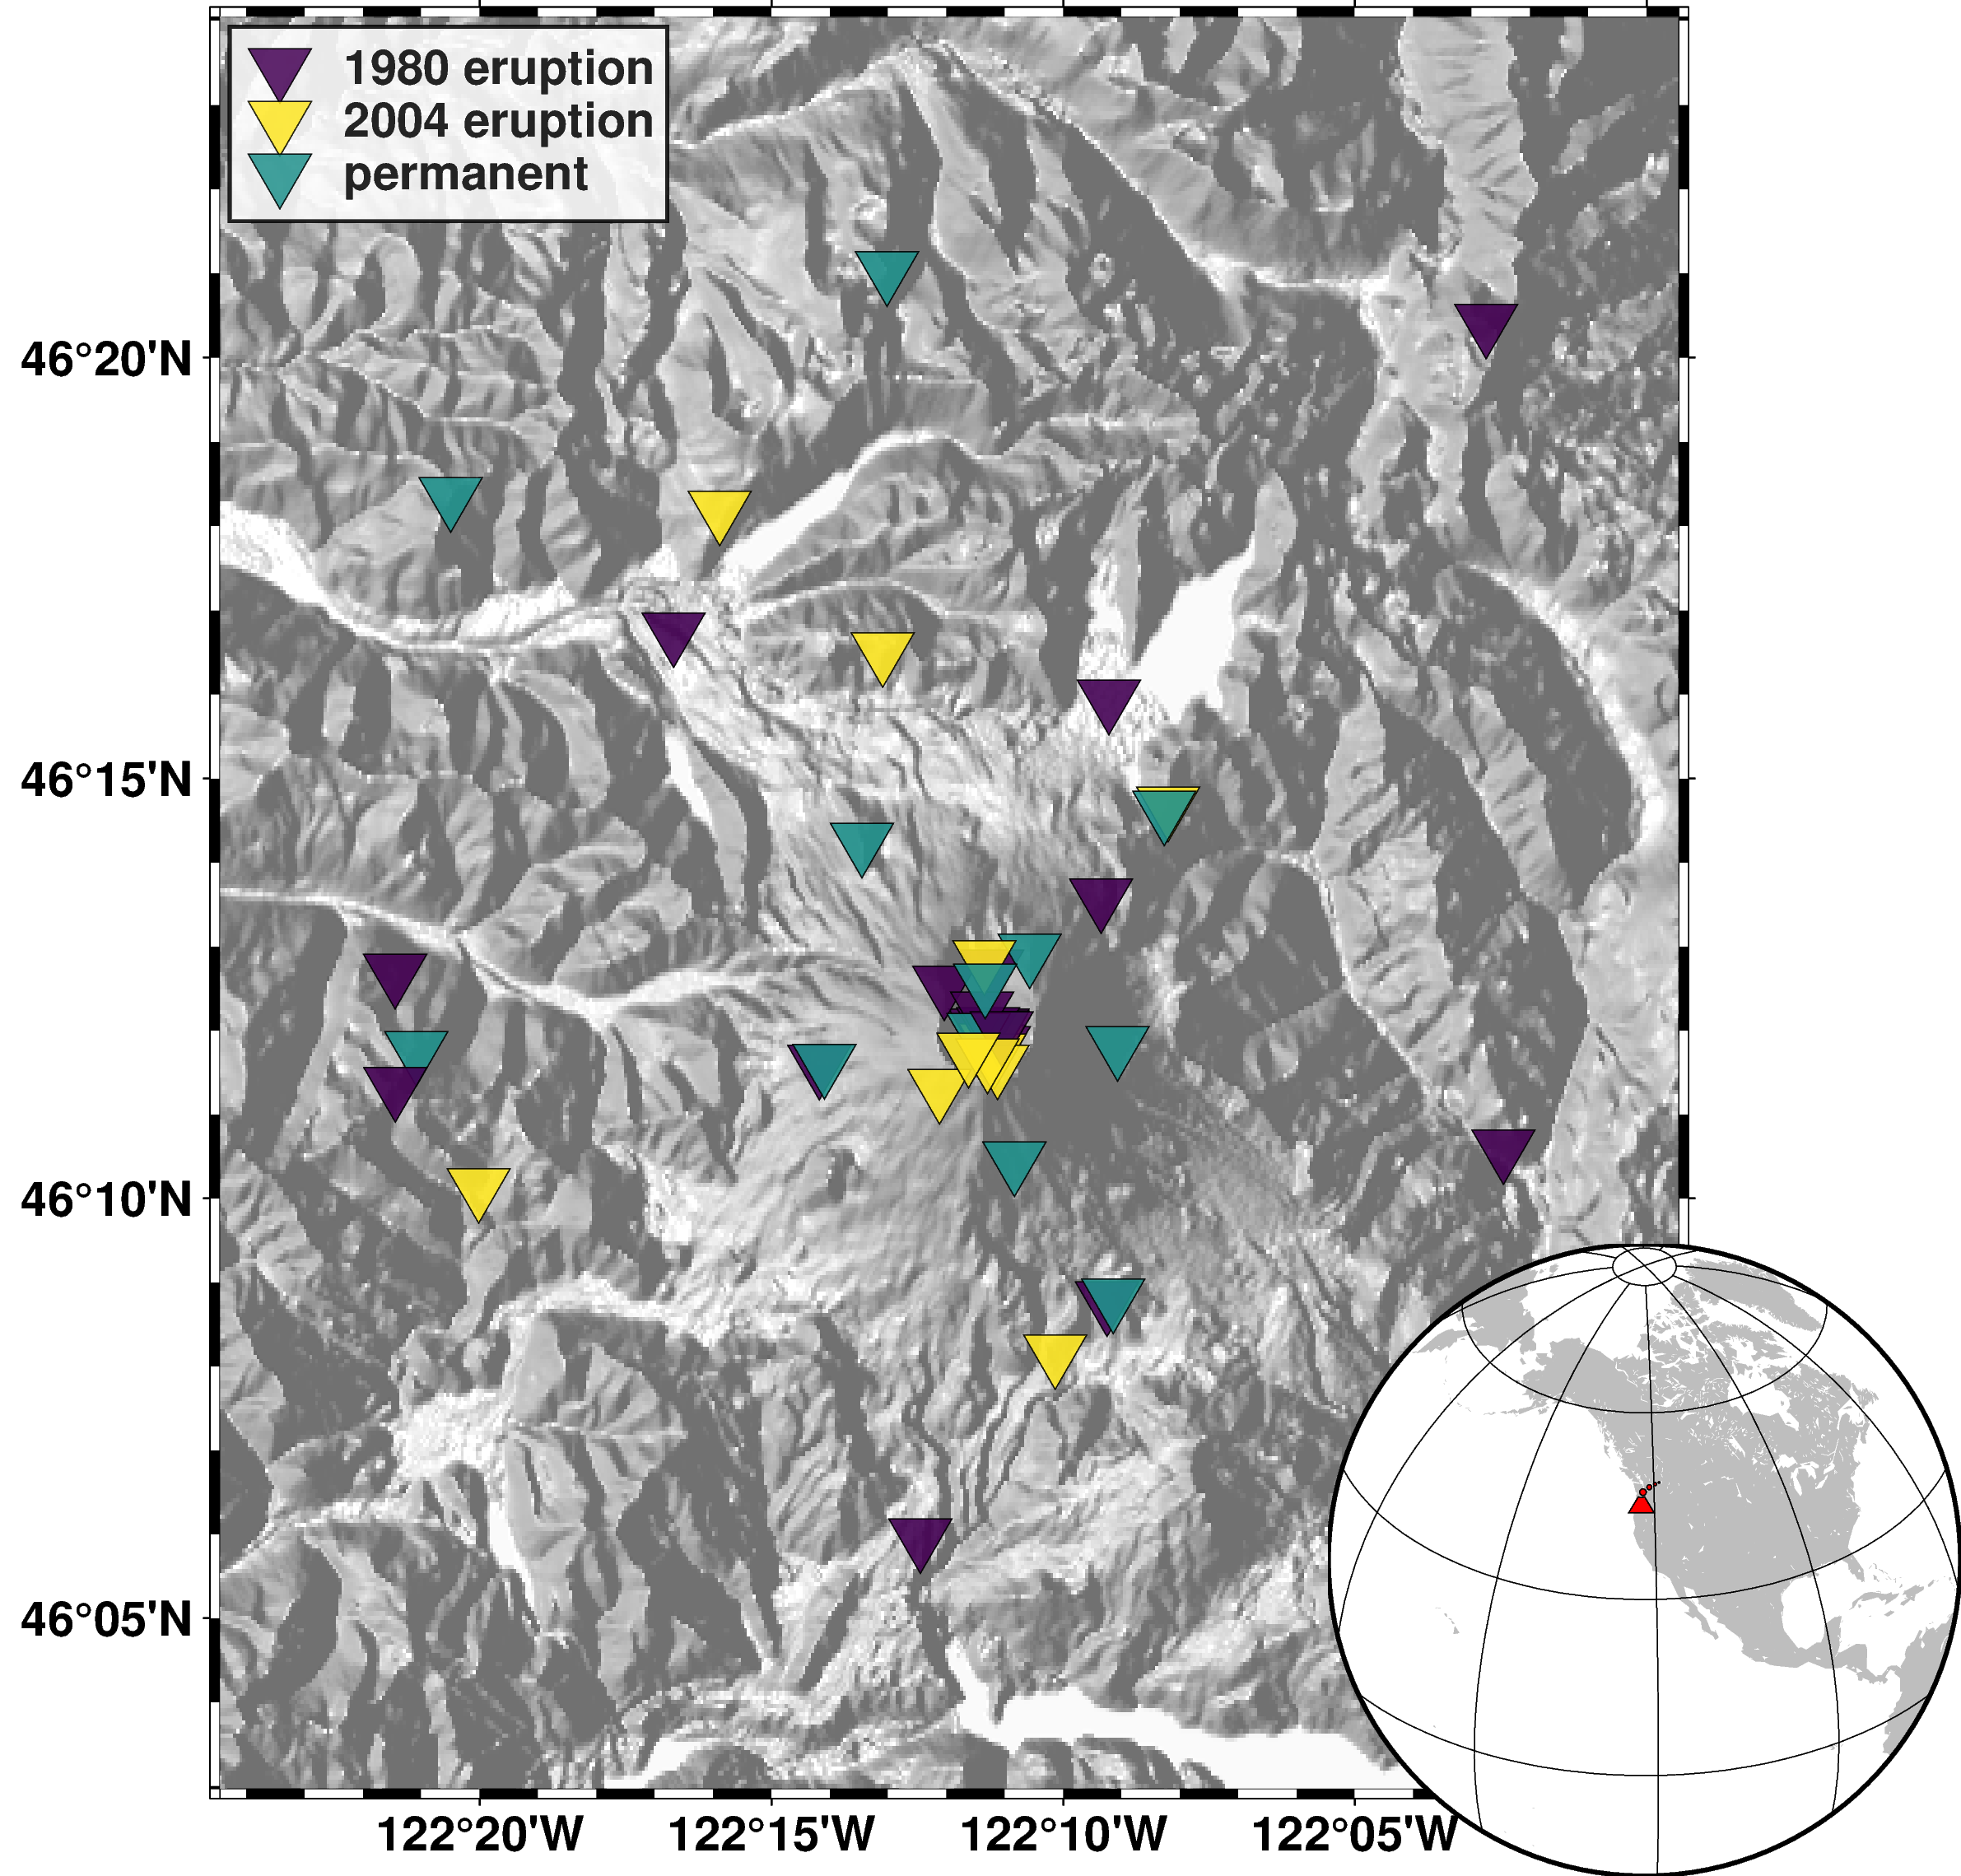

In [29]:
# stats = pd.read_csv('sta_log_long.txt', sep='|', header=0)
# 2 is lat 3 is lon
region = [
    stats.Longitude.min() - .05,
    stats.Longitude.max() + .05,
    stats.Latitude.min() - .05,
    stats.Latitude.max() + .05,
]

helen = (46.191, -122.196)

pygmt.config(FONT='14p,Helvetica-Bold')
pygmt.makecpt(cmap="gray", series=[-1.5, 0.3, 0.01])
fig = pygmt.Figure()
# Load sample grid (3 arc-seconds global relief) in target area
grid = pygmt.datasets.load_earth_relief(resolution='03s', region=region)
# calculate the reflection of a light source projecting from west to east
# (azimuth of 270 degrees) and at a latitude of 30 degrees from the horizon
dgrid = pygmt.grdgradient(grid=grid, radiance=[270, 30])

fig.basemap(region=region, projection="M15c", frame=True)
fig.grdimage(transparency='20',grid=dgrid, projection="M15c", cmap=True) #cmap="geo")

for i in stats.index:
    fig.plot(
        x=stats.Longitude[i], y=stats.Latitude[i], style="i0.75c",
        fill=stats.str_color[i], transparency='10', pen="black")
    
# legende
fig.plot(
    x=np.nan, y=np.nan, style="i0.75c",
    fill=color_str_list[2], transparency='0',
    pen="black", label='1980 eruption')
fig.plot(
    x=np.nan, y=np.nan, style="i0.75c",
    fill=color_str_list[0], transparency='0',
    pen="black", label='2004 eruption')
fig.plot(
    x=np.nan, y=np.nan, style="i0.75c",
    fill=color_str_list[1], transparency='0',
    pen="black", label='permanent')

fig.legend(
    transparency=15, box="+gwhite+p1p", position="jTL+jTL+w4.5c/2.c+o0.1c")

# fig.colorbar(frame=["a2000", "x+lElevation", "y+lm"])

lonmid = (region[0] + region[1])/2
latmid = (region[2] + region[3])/2 - 10
with fig.inset(position="jBR+w6.5c/6.5c+o-2.9c/-.9c"):
    fig.coast(
        projection=f"G{lonmid}/{latmid}/60/6.5c", region="g", frame="g",
        land="gray", water='white')
    fig.plot(
        x=helen[1], y=helen[0], style="kvolcano/0.33c", fill="red",
        pen="black", projection=f"G{lonmid}/{latmid}/60/6.5c")

fig.savefig('station_map_1980_2004_hillshade3.png', dpi=300) # , transparent=True
fig.show()


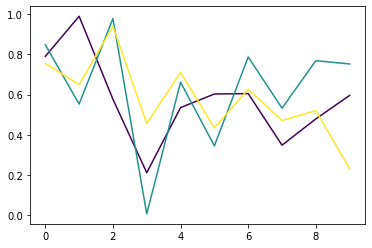

In [37]:
import matplotlib.pyplot as plt
plt.plot(range(10), np.random.rand(10), color=test_c[0])
plt.plot(range(10), np.random.rand(10), color=test_c[1])
plt.plot(range(10), np.random.rand(10), color=test_c[2])

In [2]:
import numpy as np
import pandas as pd
from obspy.core import UTCDateTime
stats = pd.read_csv('sta_log_long.txt', sep='|', header=0)
# stats = stats.groupby('Station').agg({'StartTime': 'min', 'EndTime': 'max','Latitude': 'first', 'Longitude': 'first', 'Elevation': 'first'}).reset_index()
stats['color'] = np.zeros(len(stats))
stats.loc[stats['Network'] == 'UW', 'color'] = '#d62728'
stats.loc[stats['Network'] == 'CC', 'color'] = '#ff7f0e'
stats.loc[stats['Network'] == 'USGS', 'color'] = '#17becf'
stats.loc[stats['Network'] == 'SNOFLO', 'color'] = 'black'

stats['transparency'] = np.full(len(stats),0)
stats.loc[stats['Network'] == 'CC', 'transparency'] = 50

stats = stats.loc[stats['Network'] != 'PB']

for i,row in stats.iterrows():
    dt = UTCDateTime(row.EndTime)-UTCDateTime(row.StartTime) # in sec
    if dt < (60*60*24*30): # 30d in sec
        stats.drop(i, inplace=True)
    elif UTCDateTime(row.EndTime)<UTCDateTime('2004-01-01'):
        stats.drop(i, inplace=True)

print(stats.shape)
stats

(40, 10)


,Network,Station,Latitude,Longitude,Elevation,Sitename,StartTime,EndTime,color,transparency
1,CC,BLIS,46.197472,-122.186569,2116.00,"Blister, Mt. St. Helens (Dome sta)",2004-10-12T00:00:00,2005-02-17T00:00:00,#ff7f0e,50
2,CC,GUAC,46.219200,-122.192330,1618.30,"Guacamole, crater of Mount St. Helens",2018-11-19T00:00:00,2599-12-31T23:59:59,#ff7f0e,50
3,CC,HOA,46.241780,-122.191830,1151.00,Hoala,2021-06-08T00:00:00,2599-12-31T23:59:59,#ff7f0e,50
4,CC,JRO,46.275270,-122.218260,1219.00,Johnston Ridge Observatory,2004-10-02T00:00:00,2599-12-31T23:59:59,#ff7f0e,50
5,CC,LOO,46.223750,-122.184390,1521.35,Loowit,2021-06-08T00:00:00,2599-12-31T23:59:59,#ff7f0e,50
6,CC,MAR,46.285320,-122.296670,679.27,Maratta,2021-06-17T00:00:00,2599-12-31T23:59:59,#ff7f0e,50
7,CC,MIBL,46.197319,-122.186913,2132.00,St Helens between BLIS and MIDE,2005-11-18T00:00:00,2007-12-31T00:00:00,#ff7f0e,50
8,CC,MIDE,46.197750,-122.187439,2132.00,Near old BLIS MSH,2005-02-16T00:00:00,2005-07-26T00:00:00,#ff7f0e,50
9,CC,NED,46.200249,-122.185493,2060.00,"NE part of old Dome, Mt. St. Helens (Dome sta)",2004-11-20T00:00:00,2013-05-01T00:00:00,#ff7f0e,50
10,CC,NFT,46.270000,-122.256110,818.16,North Fork Toutle,2021-06-08T00:00:00,2599-12-31T23:59:59,#ff7f0e,50


In [4]:
# Selecting rows where 'Network' is 'UW'
uw_stats = stats[stats['Network'] == 'UW']

# Calculating the average over the 'Elevation' column for the selected rows
average_elevation = uw_stats['Elevation'].mean()

print("Average elevation for Network 'UW':", round(average_elevation))

Average elevation for Network 'UW': 1454


grdcut [WARNING]: (w - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
grdcut [WARNING]: w reset from -122.401486 to -122.401666667
grdcut [WARNING]: (e - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
grdcut [WARNING]: e reset from -121.99625 to -121.995833333
grdcut [WARNING]: (s - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
grdcut [WARNING]: s reset from 46.06712 to 46.0666666667
grdcut [WARNING]: (n - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
grdcut [WARNING]: n reset from 46.40067 to 46.4008333333


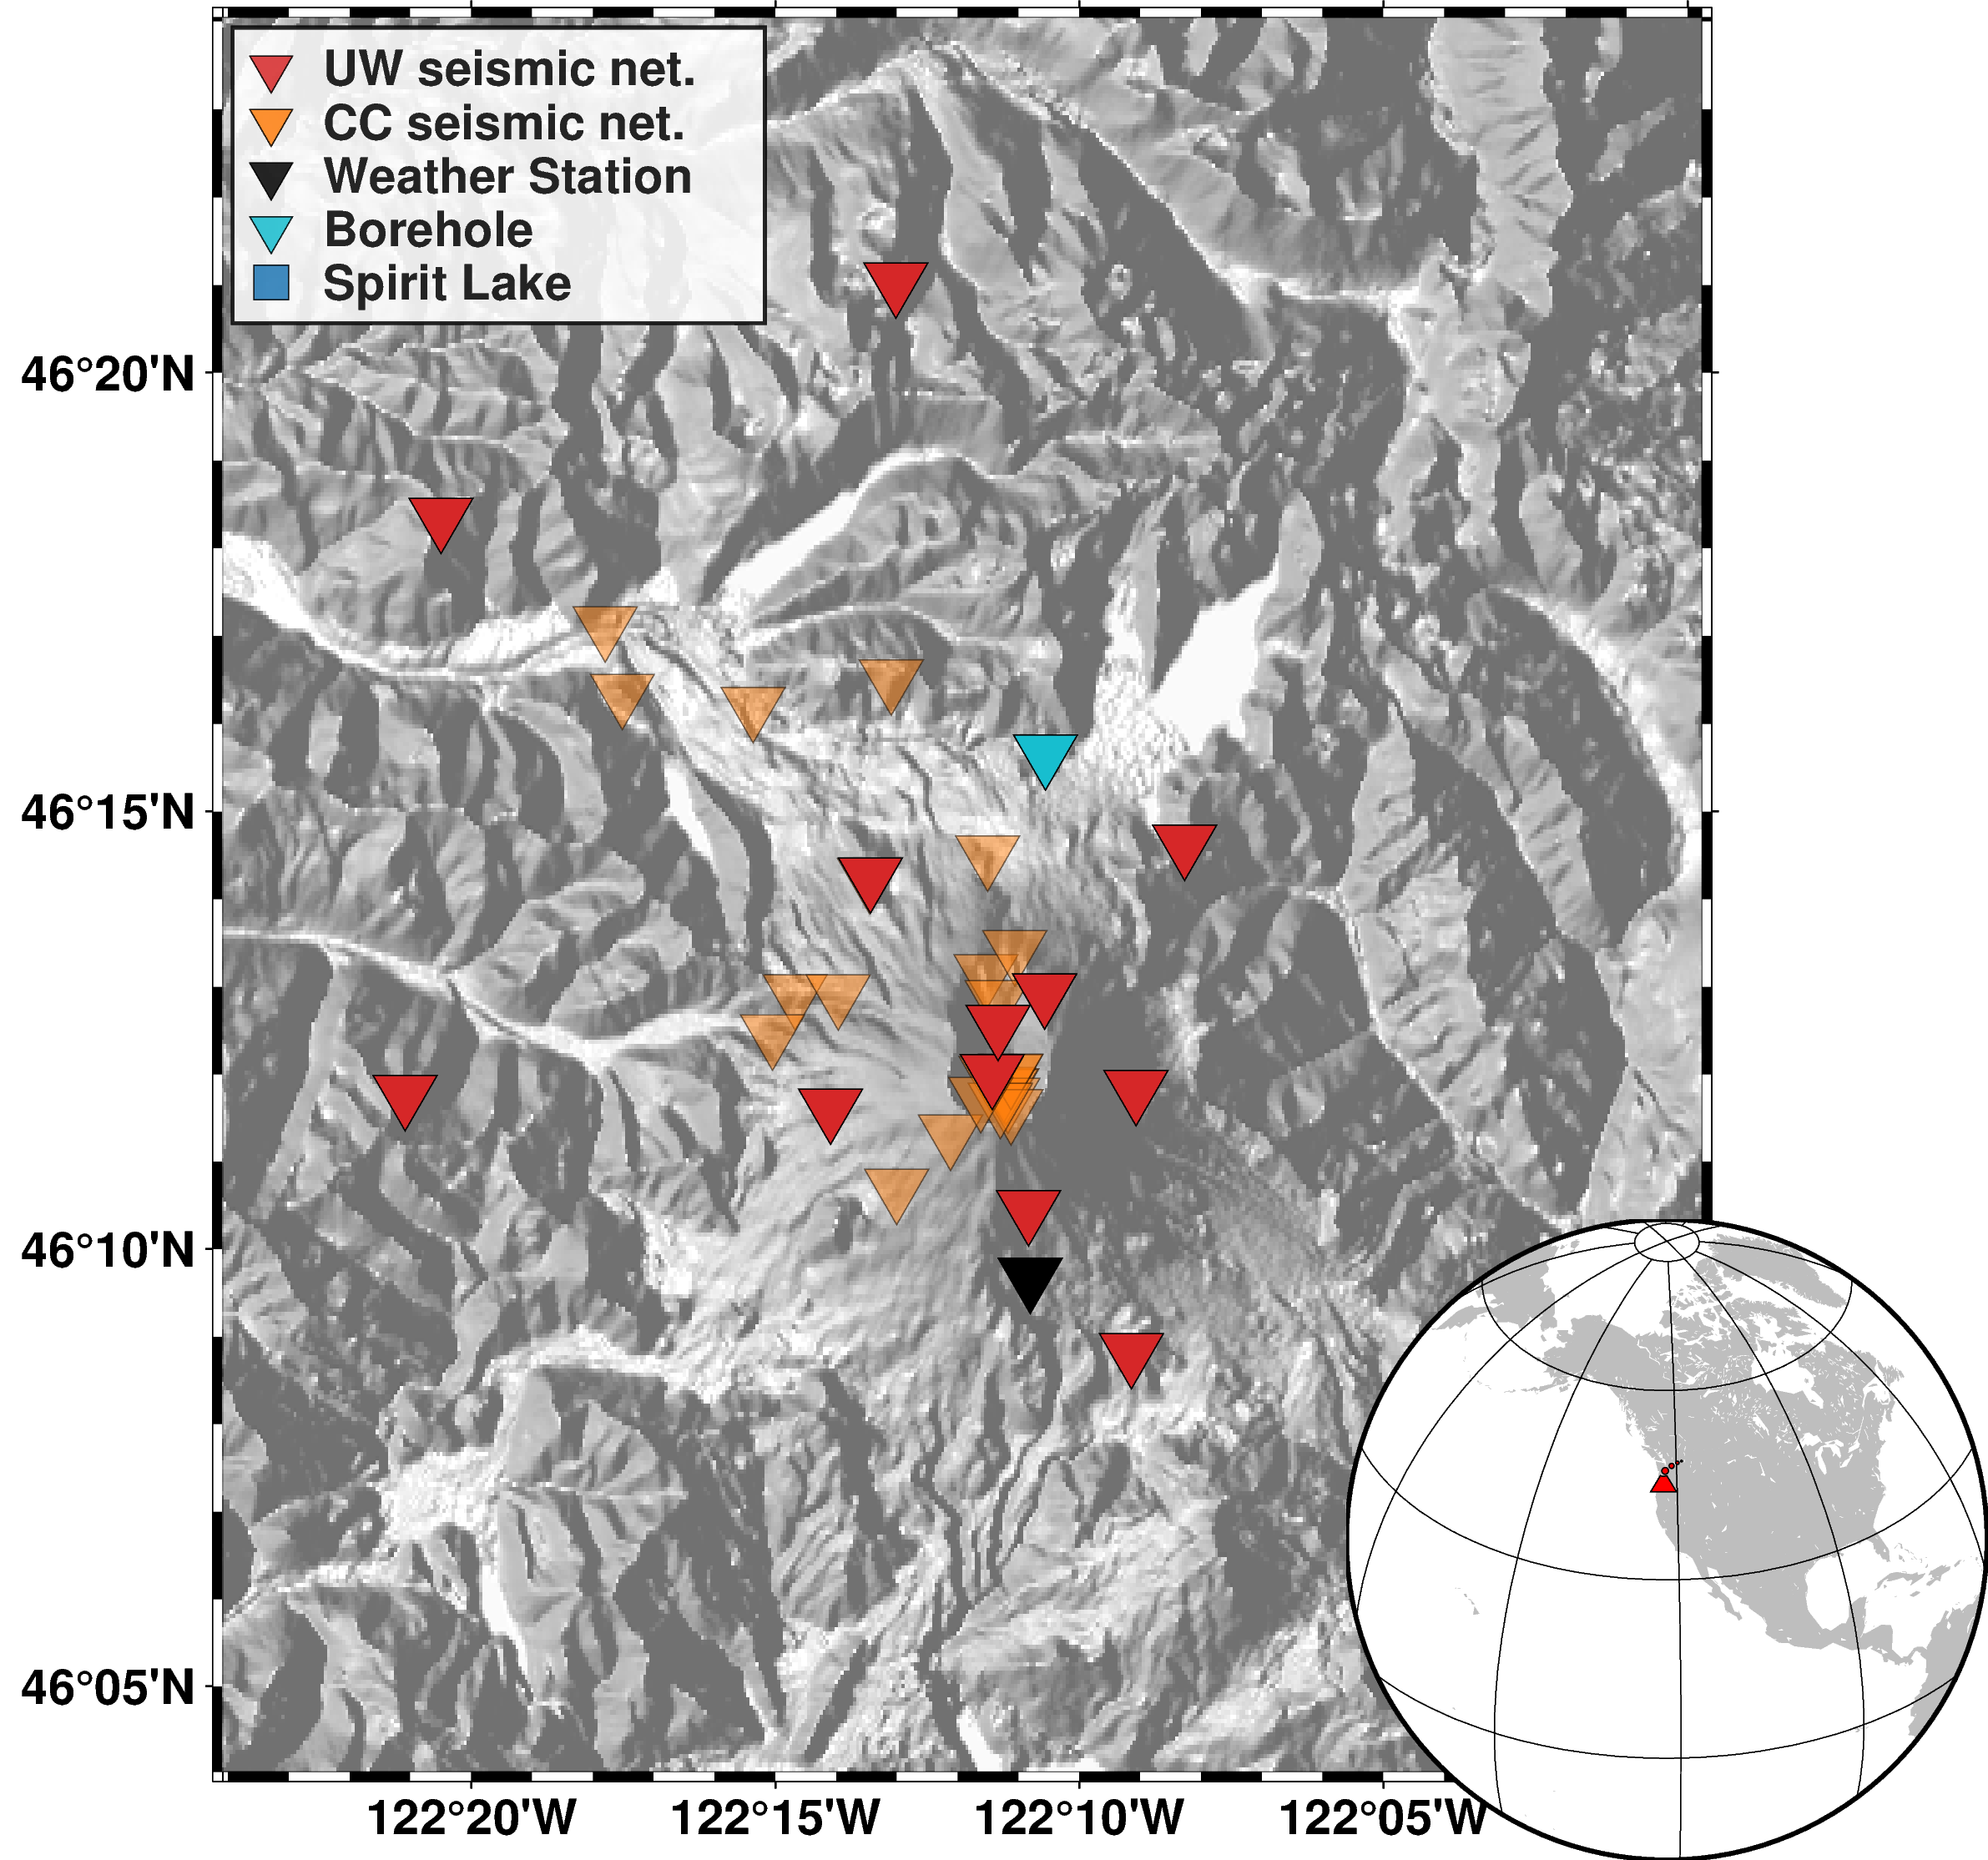

In [100]:
import numpy as np
import pygmt
import pandas as pd


# stats = pd.read_csv('sta_log_long.txt', sep='|', header=0)
# 2 is lat 3 is lon
region = [
    stats.Longitude.min() - .05,
    stats.Longitude.max() + .05,
    stats.Latitude.min() - .05,
    stats.Latitude.max() + .05,
]

helen = (46.191, -122.196)



pygmt.config(FONT='14p,Helvetica-Bold')
pygmt.makecpt(cmap="gray", series=[-1.5, 0.3, 0.01])
fig = pygmt.Figure()
# Load sample grid (3 arc-seconds global relief) in target area
grid = pygmt.datasets.load_earth_relief(resolution='03s', region=region)
# calculate the reflection of a light source projecting from west to east
# (azimuth of 270 degrees) and at a latitude of 30 degrees from the horizon
dgrid = pygmt.grdgradient(grid=grid, radiance=[270, 30])

fig.basemap(region=region, projection="M15c", frame=True)
fig.grdimage(transparency='20', grid=dgrid, projection="M15c", cmap=True) #cmap="geo")

for i in stats.index:
    fig.plot(
        x=stats.Longitude[i], y=stats.Latitude[i], style="i0.75c",
        fill=stats.color[i],pen="black", transparency=stats.transparency[i])
    
# legende
fig.plot(
    x=np.nan, y=np.nan, style="i0.5c", pen="black",
    fill='#d62728', transparency=25,
    label='UW seismic net.')
fig.plot(
    x=np.nan, y=np.nan, style="i0.5c", pen="black",
    fill='#ff7f0e', transparency=25,
    label='CC seismic net.')
fig.plot(
    x=np.nan, y=np.nan, style="i0.5c", pen="black",
    fill='black', transparency=25,
    label='Weather Station')
fig.plot(
    x=np.nan, y=np.nan, style="i0.5c", pen="black",
    fill='#17becf', transparency=25,
    label='Borehole')
fig.plot(
    x=np.nan, y=np.nan, style="s0.5c", pen="black",
    fill='#1f77b4', transparency=25,
    label='Spirit Lake')

fig.legend(transparency=15, box="+gwhite+p1p", position="jTL+jTL+w5.4c/3.c+o0.1c")

lonmid = (region[0] + region[1])/2
latmid = (region[2] + region[3])/2 - 10
with fig.inset(position="jBR+w6.5c/6.5c+o-2.9c/-.9c"):
    fig.coast(
        projection=f"G{lonmid}/{latmid}/60/6.5c", region="g", frame="g",
        land="gray", water='white')
    fig.plot(
        x=helen[1], y=helen[0], style="kvolcano/0.33c", fill="red",
        pen="black", projection=f"G{lonmid}/{latmid}/60/6.5c")

# fig.savefig('station_map_water_2004_hillshade222.png', dpi=300)
fig.show()


In [38]:
 import pandas as pd
from obspy.core import UTCDateTime
stats = pd.read_csv('sta_short.txt', sep='|', header=0)
# stats = stats.groupby('Station').agg({'StartTime': 'min', 'EndTime': 'max','Latitude': 'first', 'Longitude': 'first', 'Elevation': 'first'}).reset_index()
stats['color'] = np.zeros(len(stats))
stats.loc[stats['Network'] == 'UW', 'color'] = '#d62728'
stats.loc[stats['Network'] == 'USGS', 'color'] = '#17becf'
stats.loc[stats['Network'] == 'SNOFLO', 'color'] = 'black'
# stats = stats.reset_index(drop=True)
print(stats.shape)
stats

(15, 9)


,Network,Station,Latitude,Longitude,Elevation,Sitename,StartTime,EndTime,color
0,UW,CDF,46.117120,-122.046250,772.0,"Cedar Flats, MSH, WA, USA",1980-03-29T00:00:00,2599-12-31T23:59:59,#d62728
1,UW,EDM,46.197170,-122.151210,1611.0,"East Dome, Mt. St. Helens, WA, USA",1980-06-01T00:00:00,2599-12-31T23:59:59,#d62728
2,UW,ELK,46.305970,-122.341670,1270.0,"Mt St Helens, Elk Rock, WA, USA",1980-05-16T00:00:00,2599-12-31T23:59:59,#d62728
3,UW,FL2,46.196220,-122.351486,1378.0,"Flat Top 2, WA, USA",1984-08-03T00:00:00,2599-12-31T23:59:59,#d62728
4,UW,HSR,46.174280,-122.180650,1720.0,"South Ridge, Mt. St. Helens, WA, USA",1985-08-12T00:00:00,2599-12-31T23:59:59,#d62728
5,UW,JUN,46.147060,-122.152428,1049.0,June Lake previous ISC code: JLK,1980-05-08T00:00:00,2599-12-31T23:59:59,#d62728
6,UW,SEP,46.200211,-122.190598,2116.0,"September lobe, Mt. St. Helens (Dome sta)",1997-09-01T00:00:00,2004-10-06T00:00:00,#d62728
7,UW,SHW,46.193640,-122.234920,1442.0,"Mt. St. Helens West, WA, USA",1972-10-01T00:00:00,2599-12-31T23:59:59,#d62728
8,UW,SOS,46.243858,-122.137871,1270.0,Source of Smith Creek previous ISC code: SOSW,1980-05-16T00:00:00,2599-12-31T23:59:59,#d62728
9,UW,STD,46.237610,-122.223961,1268.0,Studebaker Ridge,1982-05-01T00:00:00,2017-09-14T00:00:00,#d62728


grdcut [WARNING]: (w - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
grdcut [WARNING]: w reset from -122.401486 to -122.401666667
grdcut [WARNING]: (e - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
grdcut [WARNING]: e reset from -121.99625 to -121.995833333
grdcut [WARNING]: (s - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
grdcut [WARNING]: s reset from 46.06712 to 46.0666666667
grdcut [WARNING]: (n - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
grdcut [WARNING]: n reset from 46.40067 to 46.4008333333


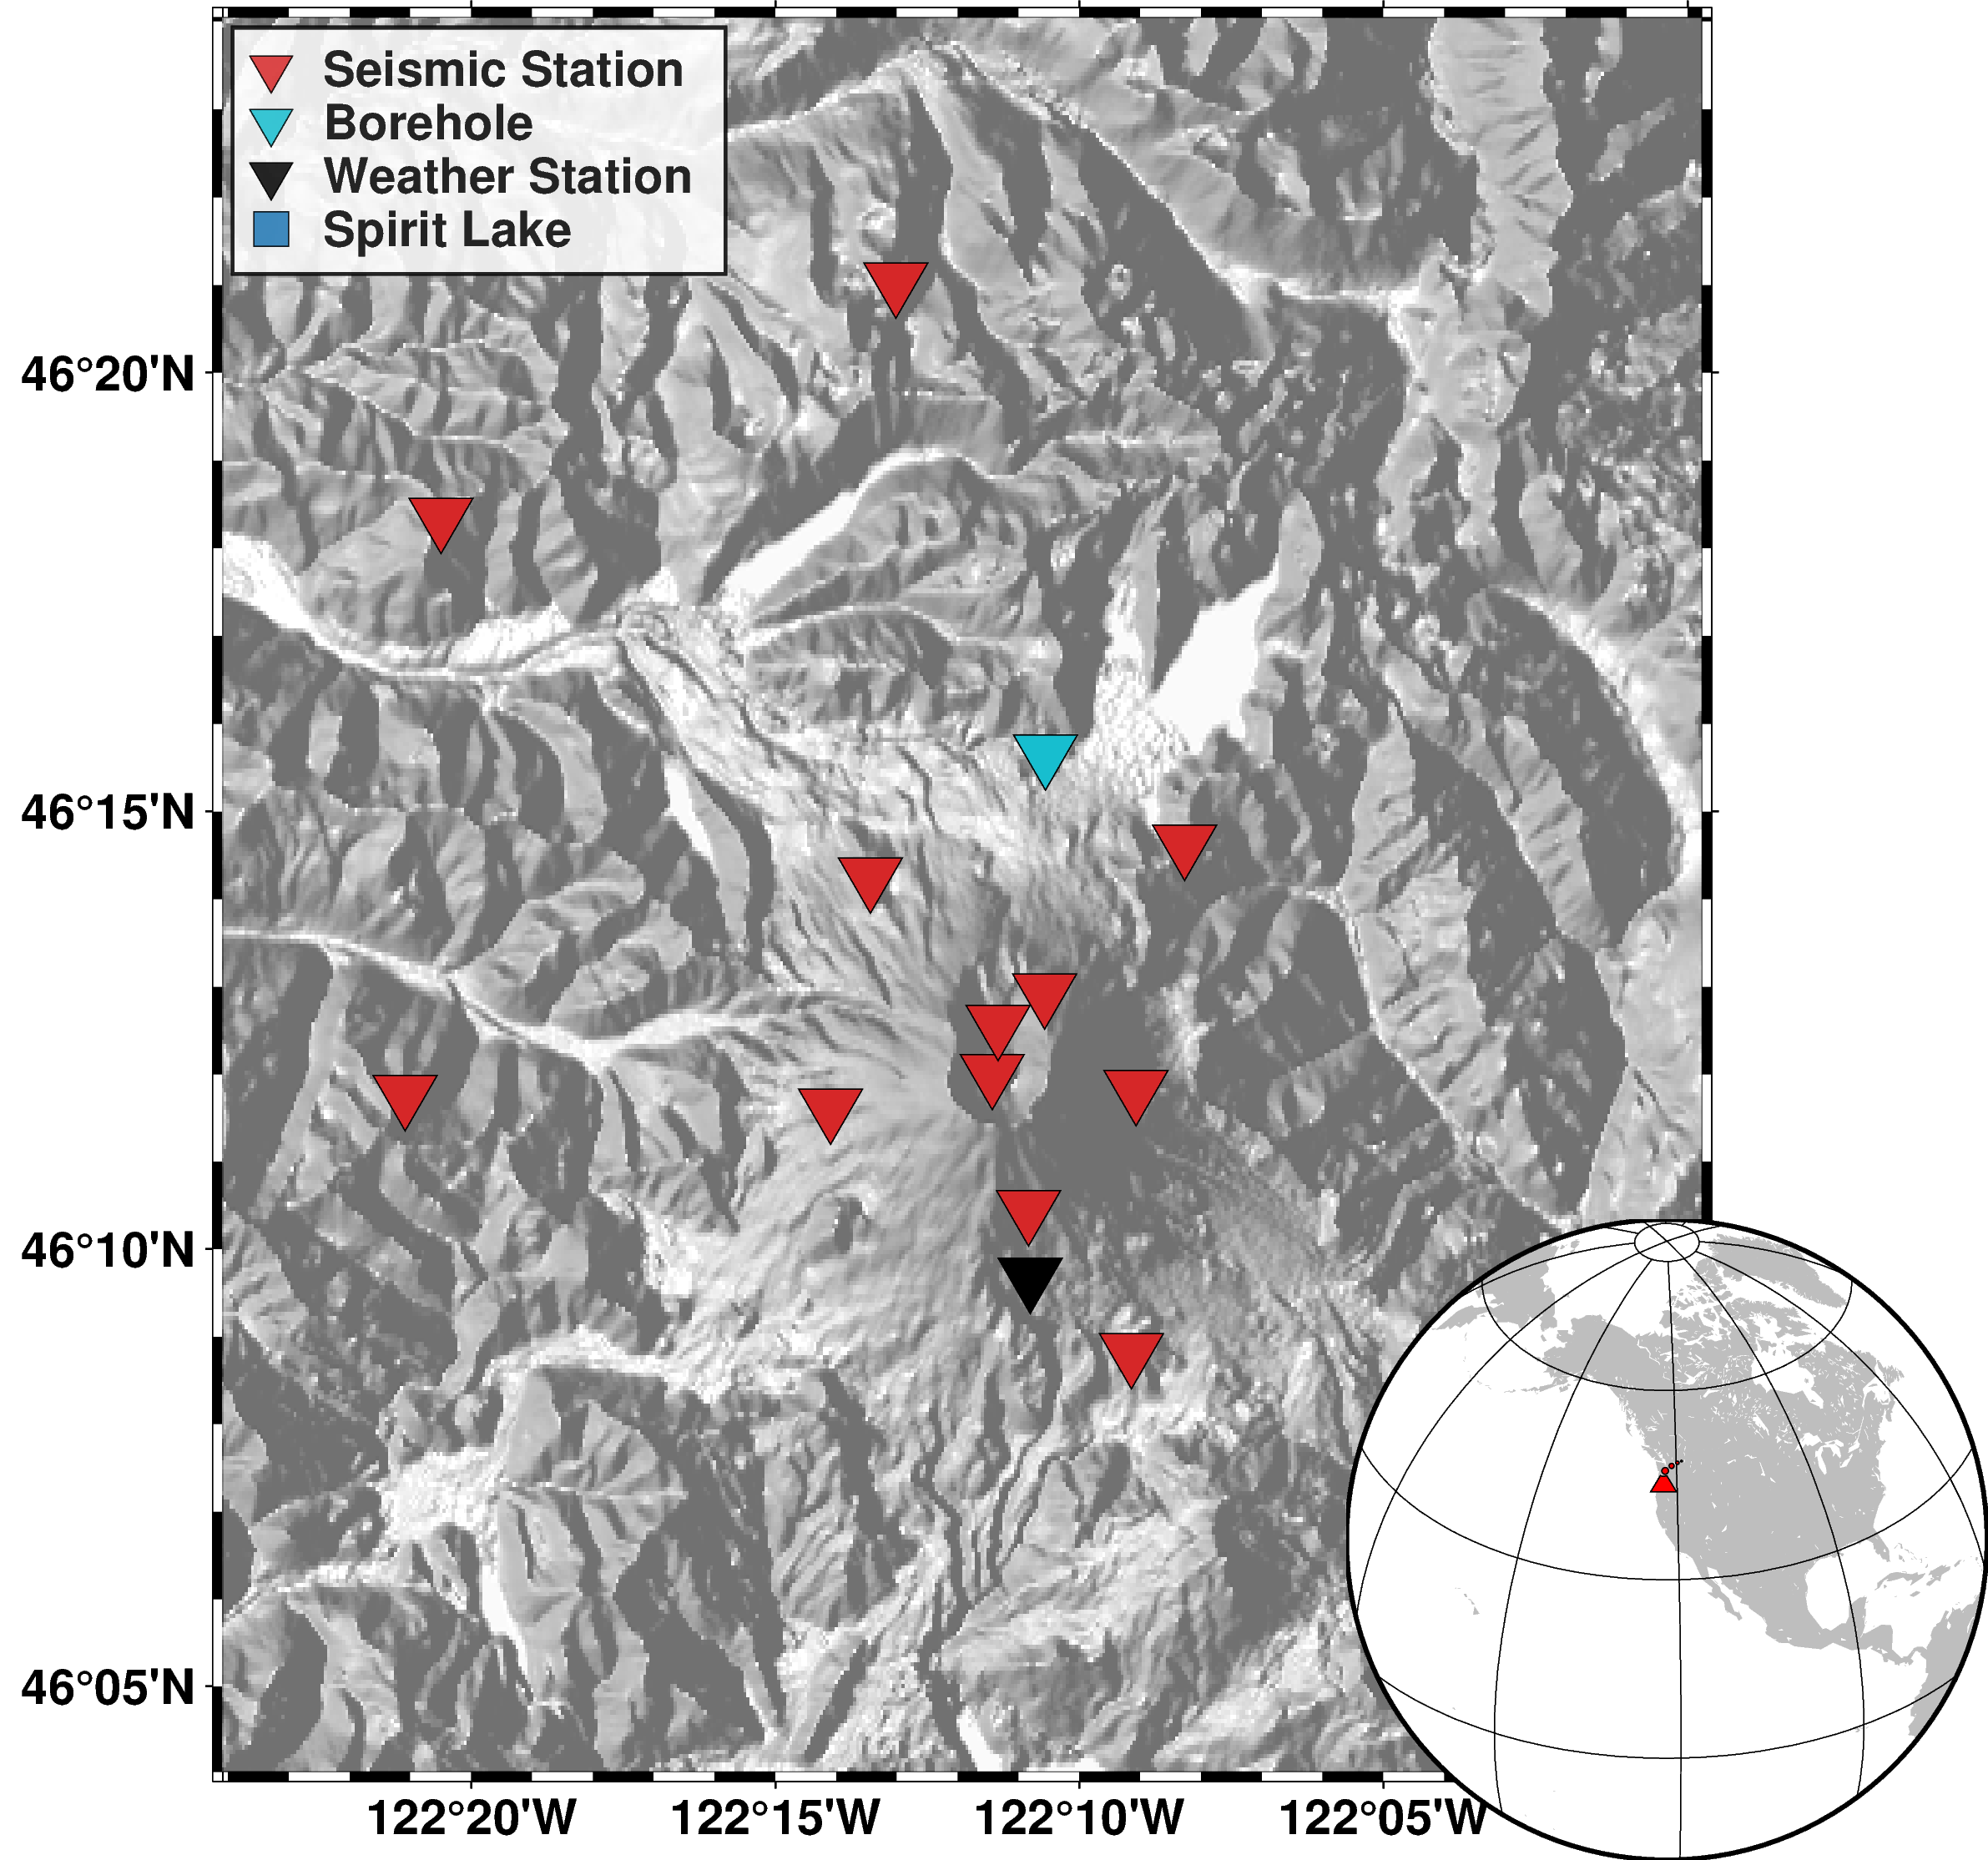

In [60]:
import numpy as np
import pygmt
import pandas as pd


# stats = pd.read_csv('sta_log_long.txt', sep='|', header=0)
# 2 is lat 3 is lon
region = [
    stats.Longitude.min() - .05,
    stats.Longitude.max() + .05,
    stats.Latitude.min() - .05,
    stats.Latitude.max() + .05,
]

helen = (46.191, -122.196)



pygmt.config(FONT='14p,Helvetica-Bold')
pygmt.makecpt(cmap="gray", series=[-1.5, 0.3, 0.01])
fig = pygmt.Figure()
# Load sample grid (3 arc-seconds global relief) in target area
grid = pygmt.datasets.load_earth_relief(resolution='03s', region=region)
# calculate the reflection of a light source projecting from west to east
# (azimuth of 270 degrees) and at a latitude of 30 degrees from the horizon
dgrid = pygmt.grdgradient(grid=grid, radiance=[270, 30])

fig.basemap(region=region, projection="M15c", frame=True)
fig.grdimage(transparency='20', grid=dgrid, projection="M15c", cmap=True) #cmap="geo")

for i in stats.index:
    fig.plot(
        x=stats.Longitude[i], y=stats.Latitude[i], style="i0.75c",
        fill=stats.color[i],pen="black", transparency=0)
    
# legende
fig.plot(
    x=np.nan, y=np.nan, style="i0.5c", pen="black",
    fill='#d62728', transparency=25,
    label='Seismic Station')
fig.plot(
    x=np.nan, y=np.nan, style="i0.5c", pen="black",
    fill='#17becf', transparency=25,
    label='Borehole')
fig.plot(
    x=np.nan, y=np.nan, style="i0.5c", pen="black",
    fill='black', transparency=25,
    label='Weather Station')
fig.plot(
    x=np.nan, y=np.nan, style="s0.5c", pen="black",
    fill='#1f77b4', transparency=25,
    label='Spirit Lake')

fig.legend(transparency=15, box="+gwhite+p1p", position="jTL+jTL+w5.c/2.5c+o0.1c")

lonmid = (region[0] + region[1])/2
latmid = (region[2] + region[3])/2 - 10
with fig.inset(position="jBR+w6.5c/6.5c+o-2.9c/-.9c"):
    fig.coast(
        projection=f"G{lonmid}/{latmid}/60/6.5c", region="g", frame="g",
        land="gray", water='white')
    fig.plot(
        x=helen[1], y=helen[0], style="kvolcano/0.33c", fill="red",
        pen="black", projection=f"G{lonmid}/{latmid}/60/6.5c")

# fig.savefig('station_map_water_2004_hillshade22.png', dpi=300)
fig.show()
